In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings
from numpy import random
import time

import desc_dc2_dm_data
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb
from astropy.wcs import WCS
import random

In [2]:
warnings.filterwarnings('ignore')

# cosmoDC2, DC2objects and Filters

In [3]:
mag_filters = [
    'mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel')
]
truth_mag_filters = (['mag_i<28','mag_i>18',(np.isfinite, 'mag_i')]) #larger cut to ensure matching between faintest objects/galaxies

In [4]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
object_data = (dc2.get_quantities(['ra', 'dec', 'mag_i_cModel','mag_r_cModel', 'mag_z_cModel', 'photoz_mean', 'x', 'y', 'Ixx_pixel', 'Iyy_pixel', 'Ixy_pixel', 'photoz_mode', 'blendedness'],
                                 filters=['extendedness>0', 'clean']+mag_filters,
                                 native_filters=['tract==4026']))

In [6]:
eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [7]:
quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'mag_r', 'mag_z', 'redshift', 'size_true', 'size_minor_true', 'position_angle_true', 'halo_id', 'halo_mass']
truth_data = (cosmodc2.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [8]:
stars_data = dc2.get_quantities(['ra', 'dec', 'mag_i_cModel','mag_r_cModel', 'mag_z_cModel', 'photoz_mean', 'x', 'y', 'Ixx_pixel', 'Iyy_pixel', 'Ixy_pixel', 'photoz_mode', 'blendedness'],
                                 filters=['extendedness==0', 'clean']+mag_filters,
                                 native_filters=['tract==4026'])

In [9]:
print("number of galaxies =", len(truth_data['ra']))
print("number of objects =", len(object_data['ra']))
print("number of stars =", len(stars_data['ra']))

number of galaxies = 2920943
number of objects = 708875
number of stars = 154206


# FoF algorithm

In [10]:
my_linking_length = 1.2

In [11]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)}, linking_lengths=my_linking_length)

In [15]:
results = results.to_pandas()

In [16]:
truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

ngal_group = len(truth_data['ra'])/n_groups
nobj_group = len(object_data['ra'])/n_groups

print(f'Linking length {my_linking_length}\'\' \nNumber of groups {n_groups} ')
print(f'Number of groups with at least 1 galaxy {len(n_truth[n_truth>0])} ({100*len(n_truth[n_truth>0])/n_groups:.2f} %)')
print(f'Number of groups with at least 1 object {len(n_object[n_object>0])} ({100*len(n_object[n_object>0])/n_groups:.2f} %)')
print(f'Average number of galaxies per group : {ngal_group:.2f} \nAverage number of objects per group : {nobj_group:.2f}')

Linking length 1.2'' 
Number of groups 2271927 
Number of groups with at least 1 galaxy 2264766 (99.68 %)
Number of groups with at least 1 object 694014 (30.55 %)
Average number of galaxies per group : 1.29 
Average number of objects per group : 0.31


# Recover groups

In [17]:
results['is_object'] = (results['catalog_key']=='object')

In [18]:
res = results.drop('catalog_key', axis=1)

In [19]:
groups = []

for group_id, rows in res.groupby('group_id'):
    id_gal = list(rows['row_index'][~rows['is_object']])
    id_obj = list(rows['row_index'][rows['is_object']])
    groups.append([id_gal, id_obj])

In [20]:
print(groups[:10])

[[[2052843], [0]], [[488380], [1]], [[485146], [2]], [[640538], [3]], [[665906, 792427], [4]], [[512965, 795342], [5]], [[642663], [6]], [[732008], [7]], [[1937653], [8]], [[2349327], [9]]]


In [109]:
group = [[],[]]
n = 2 #number of galaxies
m = 1 #number of objects

while (len(group[0]) != n) | (len(group[1]) != m): #choose which system you want to study
    group = groups[random.randint(0,len(groups))]

print(group)

[[2204471, 2406318], [409892]]


# Parameters of ellipses 

In [1028]:
def ellipse_equation(x, y, params): #ellipse equation
    
    A, B, C, D, E, F = params
    
    return A*x**2 + B*y**2 + 2*C*x*y + 2*D*x + 2*E*y + F

In [1029]:
def ab2AB(a, b, theta, x0, y0): #converts semi-axis a and b and theta angle in A,B,C,D,E,F parameters
    
    ### a, b, in any length units; theta in degrees ###
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))
    
    A = (a*sin)**2 + (b*cos)**2
    B = (a*cos)**2 + (b*sin)**2
    C = 2*(b**2 - a**2)*sin*cos
    D = -2*A*x0 - C*y0
    E = -C*x0 - 2*B*y0
    F = A*x0**2 + C*x0*y0 + B*y0**2 - (a*b)**2
    C, D, E = C/2, D/2, E/2
    
    return [A, B, C, D, E, F]

# Computation of the parameters of ellipses - Objects

In [1030]:
idx2 = group[1] #indices of objects
print(idx2)

[122804]


### Calculate a, b, theta ellipse parameters from the second moments of the object catalog

In [1031]:
def moments2ab(Ixx, Iyy, Ixy): #converts second moments in a,b and theta parameters !!! Using a Gaussian flux distribution !!!
    
    ### Ixx, Iyy, Ixy in same unit as (x0, y0) ###
   
    theta2 = np.arctan2(2*Ixy, Ixx-Iyy)
    theta2[theta2<0] += 2*np.pi
    
    theta = theta2 / 2
    
    sin = np.sin(theta)
    cos = np.cos(theta)
    cos2t = cos**2 - sin**2
    
    a_square = 2*np.log(2)*(Ixx*cos**2 - Iyy*sin**2) / cos2t
    b_square = 2*np.log(2)*(Iyy*cos**2 - Ixx*sin**2) / cos2t
    
    return [np.sqrt(a_square), np.sqrt(b_square), np.degrees(theta)]

In [1032]:
Ixx = object_data['Ixx_pixel'][idx2]
Iyy = object_data['Iyy_pixel'][idx2]
Ixy = object_data['Ixy_pixel'][idx2]

x0 = object_data['x'][idx2]
y0 = object_data['y'][idx2]

a2, b2, theta2 = moments2ab(Ixx, Iyy, Ixy)

In [1033]:
ra2 = object_data['ra'][idx2]
dec2 = object_data['dec'][idx2]

### Calculate the A, B, C, D, E, F parameters

In [1034]:
#fudge = 1.5 #fudge factor (constant for the moment)

p_obj = []

for m in range(len(idx2)):
    p_obj.append(np.ravel(ab2AB(a2[m], b2[m], theta2[m], x0[m], y0[m])))

print(p_obj)

[array([ 9.21909817e+00,  8.82463324e+00, -1.27200283e+00, -7.97199665e+04,
       -2.11278973e+05,  6.40180168e+09])]


### Plot object ellipses

In [1035]:
def plot_shape(x0, y0, rough_size, params, c='b', ls='-', ax=None, linewidth=2): #plot function
    
    x = np.linspace(x0 - rough_size, x0 + rough_size, 100)
    y = np.linspace(y0 - rough_size, y0 + rough_size, 100)
    x, y = np.meshgrid(x,y)
 
    z = ellipse_equation(x, y, params)
    
    ax.contour(x, y, z, [0], colors=c, linestyles=ls, linewidths=linewidth) 

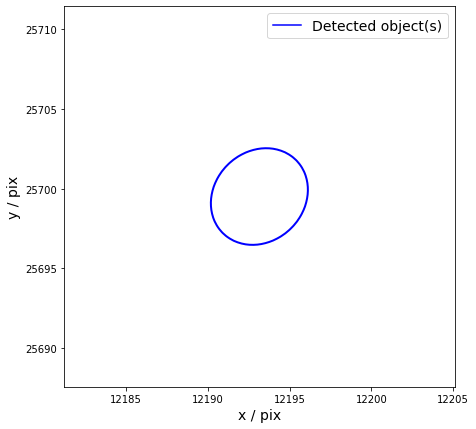

In [1036]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
 
rough_size = 4*np.sqrt(a2[0]*b2[0])

for m in range(len(idx2)):
    plot_shape(x0[m], y0[m], rough_size, p_obj[m], c='b', ls='-', ax=ax)

ax.set_xlabel('x / pix', fontsize=14)
ax.set_ylabel('y / pix', fontsize=14)

ax.plot([], [], 'b', label='Detected object(s)')

ax.legend(prop={'size':14})

# Computation of the parameters of ellipses - Galaxies

### Parameters of ellipse 1 (galaxy)

In [1037]:
idx1 = group[0] #indices of the galaxies
print(idx1)

[30101, 30102]


### Measure the PSF by looking at stars

In [1038]:
Ixx = stars_data['Ixx_pixel'][~np.isnan(stars_data['Ixx_pixel'])] ## in pixels
Iyy = stars_data['Iyy_pixel'][~np.isnan(stars_data['Iyy_pixel'])] ## in pixels

stars_data['r_tp'] = np.power(2*(Ixx + Iyy)/np.pi, 1/4)
stars_data['r_gauss' ] = np.sqrt(np.log(2) * (Ixx+Iyy))
#stars_data['r_fudge'] = 1.5 * stars_data['r'] ## fudge factor for the constant-flux disk model

psf = np.median(stars_data['r_gauss']) * 0.2 / 3600    ## in degree; pixel ratio is 0.2"/pix
print(psf)

0.00011259314083096866


### Convert a, b, theta in (ra, dec, deg) plane to a, b, theta in (pixels) plane and convolute with the psf

In [1039]:
ra1 = truth_data['ra'][idx1] #in degrees
dec1 = truth_data['dec'][idx1] #in degrees

a = truth_data['size_true'][idx1] / 3600. #arcsec to degree
b = truth_data['size_minor_true'][idx1] / 3600. #arcsec to degree
a_eff = np.sqrt( a**2 + psf**2) #in degree (with the effect of the PSF)
b_eff = np.sqrt( b**2 + psf**2) #in degree (with the effect of the PSF)

a1 = a_eff * 3600 / 0.2 #in pixels (pixel ratio is 0.2"/pix)
b1 = b_eff * 3600 / 0.2 #in pixels (pixel ratio is 0.2"/pix)

theta1 = 270 - truth_data['position_angle_true'][idx1]
theta1[theta1>180] -= 180

### Calculate the positions of galaxies in pixels plan from the position of objects

In [1040]:
dx = (((ra2[0] - ra1) * np.cos(np.radians( (dec1+dec2[0]) / 2 )) * 3600 / 0.2)) #pixel displacement with respect to the position of the object #1 
dy = ((dec2[0] - dec1) * 3600 / 0.2)

print(dx, dy)

[-0.04138929  0.79312944] [ 0.63665844 -2.40972081]


### Calculate the A,B,C,D,E,F parameters

In [1041]:
p_gal = []

for n in range(len(idx1)):
    p_gal.append(np.ravel(ab2AB(a1[n], b1[n], theta1[n], x0[0]+dx[n], y0[0]+dy[n]))) #pixel position with respect to the position of the object #1 
    
print(p_gal)

[array([ 5.38138671e+00,  6.07703093e+00, -1.27099968e-01, -6.23493224e+04,
       -1.54630800e+05,  4.73426493e+09]), array([ 5.37370086e+00,  5.66544583e+00,  6.23061575e-01, -8.15374509e+04,
       -1.53183065e+05,  4.93062216e+09])]


### Plot galaxy ellipses

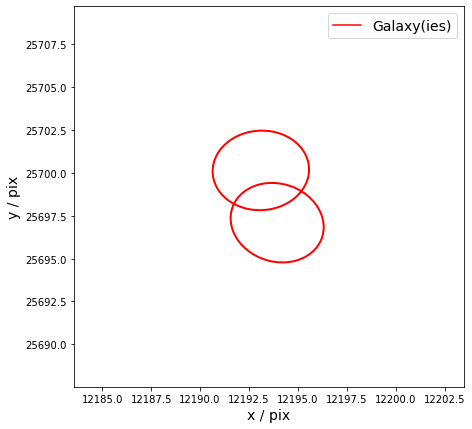

In [1042]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
 
rough_size = 4*np.sqrt(a1[0]*b1[0])

for n in range(len(idx1)):
    plot_shape(x0[0]+dx[n], y0[0]+dy[n], rough_size, p_gal[n], c='r', ls='-', ax=ax)

ax.set_xlabel('x / pix', fontsize=14)
ax.set_ylabel('y / pix', fontsize=14)

ax.plot([], [], 'r', label='Galaxy(ies)')

ax.legend(prop={'size':14})

# Test of overlapp

In [1043]:
def is_overlapping(p1, p2):
    
    A1, B1, C1, D1, E1, F1 = p1
    A2, B2, C2, D2, E2, F2 = p2
        
    M1 = [[A1, C1, D1], 
          [C1, B1, E1], 
          [D1, E1, F1]]
    
    M2 = [[A2, C2, D2], 
          [C2, B2, E2], 
          [D2, E2, F2]]
    
    
    l0 = np.linalg.det(M2)
    
    l1 = (np.linalg.det([[A1,C2,D2],
                         [C1,B2,E2],
                         [D1,E2,F2]])
        + np.linalg.det([[A2,C1,D2],
                         [C2,B1,E2],
                         [D2,E1,F2]]) 
        + np.linalg.det([[A2,C2,D1],
                         [C2,B2,E1],
                         [D2,E2,F1]])) / 3
    
    l2 = (np.linalg.det([[A2,C1,D1],
                         [C2,B1,E1],
                         [D2,E1,F1]]) 
         + np.linalg.det([[A1,C2,D1],
                          [C1,B2,E1],
                          [D1,E2,F1]]) 
         + np.linalg.det([[A1,C1,D2],
                          [C1,B1,E2],
                          [D1,E1,F2]])) / 3
    
    l3 = np.linalg.det(M1)
    

    delta1 = np.linalg.det([[l3, l2],
                            [l2, l1]])
    delta2 = np.linalg.det([[l3, l1],
                            [l2, l0]])
    delta3 = np.linalg.det([[l2, l1],
                            [l1, l0]])
    
    discriminant_P = np.linalg.det([[2*delta1, delta2], 
                                    [delta2, 2*delta3]])
    
    if (discriminant_P >=0) and ((l1>0) or (l2>0)):
        return False  ## not over-lapping
    else:
        return True

In [1044]:
for n in range(len(p_gal)):
    for m in range(len(p_obj)):
        print(f'galaxy {n+1} overlaps object {m+1} ?', is_overlapping(p_gal[n], p_obj[m]))

galaxy 1 overlaps object 1 ? True
galaxy 2 overlaps object 1 ? True


In [1045]:
connectivity = {}
for m in range(len(p_obj)):
    c = 0
    for n in range(len(p_gal)):
        if is_overlapping(p_gal[n], p_obj[m]) == True:
            c += 1
    connectivity[f'object {m+1}'] = c

In [1046]:
print(f'{len(idx1)}-{len(idx2)} system ')
print('linking length =', my_linking_length)
print('connectivity =', connectivity)

2-1 system 
linking length = 1.2
connectivity = {'object 1': 2}


### Plot ellipses

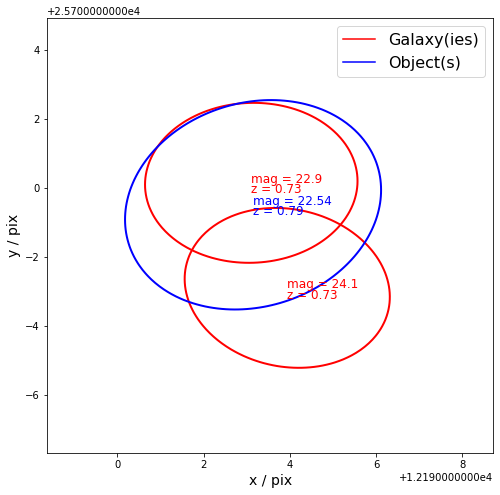

In [1047]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
rough_size = 2*np.sqrt(a1[0]*b1[0])

for n in range(len(idx1)):
    plot_shape(x0[0]+dx[n], y0[0]+dy[n], rough_size, p_gal[n], c='r', ls='-', ax=ax)    
    plt.text(x0[0]+dx[n], y0[0]+dy[n], 'mag = ' + str(round(float(truth_data['mag_i'][idx1[n]]),2)), c='r', fontsize=12)
    plt.text(x0[0]+dx[n], y0[0]+dy[n]-0.3, 'z = ' + str(round(float(truth_data['redshift'][idx1[n]]),2)), c='r', fontsize=12)
 
for m in range(len(idx2)):
    plot_shape(x0[m], y0[m], rough_size, p_obj[m], c='b', ls='-', ax=ax)
    plt.text(x0[m], y0[m], 'mag = ' + str(round(float(object_data['mag_i_cModel'][idx2[m]]),2)), c='b', fontsize=12)
    plt.text(x0[m], y0[m]-0.3, 'z = ' + str(round(float(object_data['photoz_mean'][idx2[m]]),2)), c='b', fontsize=12)

ax.set_xlabel('x / pix', fontsize=14)
ax.set_ylabel('y / pix', fontsize=14)

ax.plot([], [], 'r', label='Galaxy(ies)')
ax.plot([], [], 'b', label='Object(s)')
ax.legend(prop={'size':16})

#plt.savefig(f'{n+1}-{m+1}.png')

# Plot ellipses + LSST simulated images

In [1048]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler('/sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr3-v1-grizy/')

lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory


In [1049]:
skymap = butler.get('deepCoadd_skyMap')

In [1050]:
patch = object_data['patch'][idx2][0]

In [1051]:
print(object_data['patch'][idx2])

['3,6']


In [1052]:
dataId = {'tract':4026, 'patch': patch, 'filter':'i'}

In [1053]:
full_patch = butler.get("deepCoadd", dataId=dataId_i)

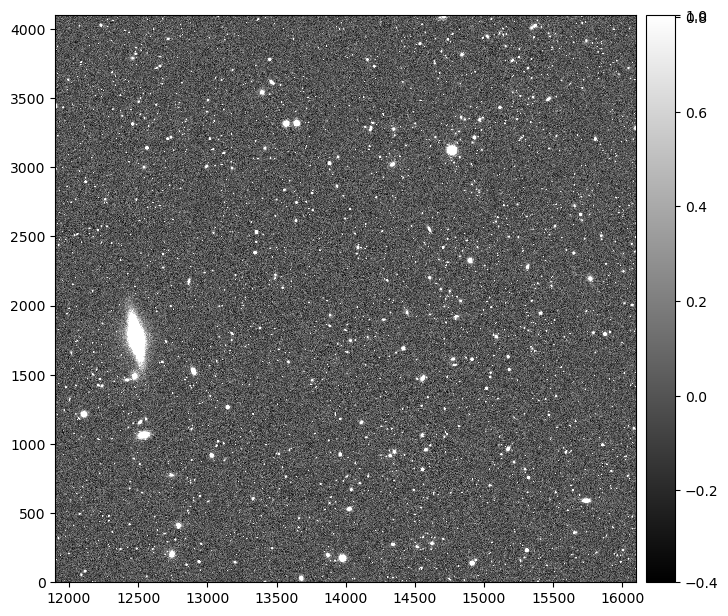

In [1054]:
fig = plt.figure(figsize=(8, 8), dpi=100)
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())

### In Grey

In [1055]:
dx_obj = (((ra2[0] - ra2) * np.cos(np.radians( (dec2+dec2[0]) / 2 )) * 3600 / 0.2)) #pixel displacement with respect to the position of the object #1 
dy_obj = ((dec2[0] - dec2) * 3600 / 0.2)

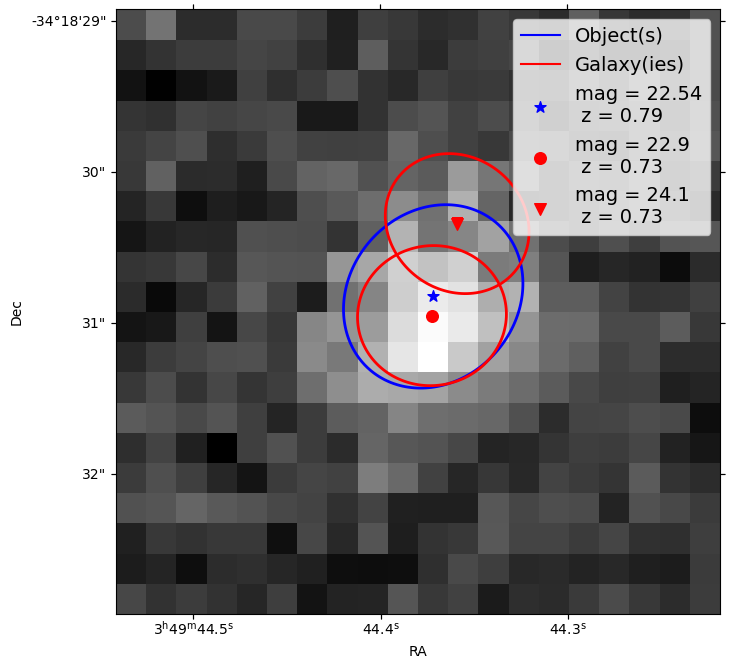

In [1056]:
markers = ['*', 'o', 'v', 's', '^', 'P']

cutout_size = 20  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

############################################################################

radec = lsst.geom.SpherePoint(ra2[0], dec2[0], lsst.geom.degrees)

center = skymap.findTract(radec).getWcs().skyToPixel(radec)

if np.floor(center.x) - np.round(center.x) == 0:
    pix_center_x = center.x
else:
    pix_center_x = center.x + 1

if np.floor(center.y) - np.round(center.y) == 0:
    pix_center_y = center.y
else:
    pix_center_y = center.y + 1

bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
wcs = cutout.getWcs()

off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
wcs_new = wcs.copyAtShiftedPixelOrigin(off)
wcs_fits_meta = wcs_new.getFitsMetadata()

image_arr = cutout.getMaskedImage().getImage().array

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(8, 8), dpi=100)
vmin, vmax = image_arr.min(), image_arr.max()

ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

############################################################################

ax.plot([], [], 'b', label='Object(s)')
ax.plot([], [], 'r', label='Galaxy(ies)')

p_obj = ab2AB(a2[0], b2[0], theta2[0], cutout_size/2, cutout_size/2)
plot_shape(cutout_size/2, cutout_size/2, rough_size, p_obj, c='b', ls='-', ax=ax)
ax.scatter(cutout_size/2, cutout_size/2, marker=markers[0], c='b', s=70, 
           label='mag = ' + str(round(float(object_data['mag_i_cModel'][idx2[0]]),2)) + '\n z = ' + str(round(float(object_data['photoz_mean'][idx2[0]]),2)))

for i in range(1, len(idx2)):
    
    p_obj = ab2AB(a2[i], b2[i], theta2[i], cutout_size/2 + dx_obj[i], cutout_size/2 - dy_obj[i])
    plot_shape(cutout_size/2 + dx_obj[i], cutout_size/2 - dy_obj[i], rough_size, p_obj, c='b', ls='-', ax=ax)
    ax.scatter(cutout_size/2 + dx_obj[i], cutout_size/2 - dy_obj[i], marker=markers[i], c='b', s=70,
              label='mag = ' + str(round(float(object_data['mag_i_cModel'][idx2[i]]),2)) + '\n z = ' + str(round(float(object_data['photoz_mean'][idx2[i]]),2)))
   
for j in range(len(idx1)):

    p_gal = ab2AB(a1[j], b1[j], theta1[j], cutout_size/2 + dx[j], cutout_size/2 - dy[j]) 
    plot_shape(cutout_size/2 + dx[j], cutout_size/2 - dy[j], rough_size, p_gal, c='r', ls='-', ax=ax)
    ax.scatter(cutout_size/2 + dx[j], cutout_size/2 - dy[j], marker=markers[len(idx2)+j], c='r', s=70,
              label='mag = ' + str(round(float(truth_data['mag_i'][idx1[j]]),2)) + '\n z = ' + str(round(float(truth_data['redshift'][idx1[j]]),2)))
    
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.legend(prop={'size':14})
plt.savefig(f'{n+1}-{m+1}.png')

### In colors

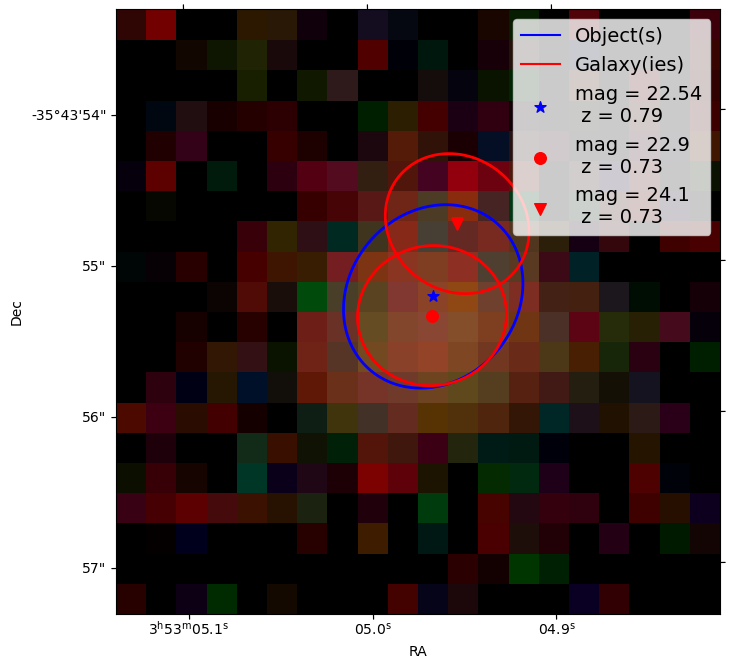

In [1057]:
markers = ['*', 'o', 'v', 's', '^', 'P']

cutout_size = 20  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

############################################################################

radec = lsst.geom.SpherePoint(ra2[0], dec2[0], lsst.geom.degrees)

center = skymap.findTract(radec).getWcs().skyToPixel(radec)

if np.floor(center.x) - np.round(center.x) == 0:
    pix_center_x = center.x
else:
    pix_center_x = center.x + 1

if np.floor(center.y) - np.round(center.y) == 0:
    pix_center_y = center.y
else:
    pix_center_y = center.y + 1

############################################################################


bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)

cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=4026, patch=patch, filter=band) for band in "irg"]

wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
image_rgb = rgb.makeRGB(*cutouts, dataRange=1, Q=10)
del cutouts  # let gc save some memory for us

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(8, 8), dpi=100)
ax.imshow(image_rgb, origin='lower')

############################################################################

ax.plot([], [], 'b', label='Object(s)')
ax.plot([], [], 'r', label='Galaxy(ies)')

p_obj = ab2AB(a2[0], b2[0], theta2[0], cutout_size/2, cutout_size/2)
plot_shape(cutout_size/2, cutout_size/2, rough_size, p_obj, c='b', ls='-', ax=ax)
ax.scatter(cutout_size/2, cutout_size/2, marker=markers[0], c='b', s=70, 
           label='mag = ' + str(round(float(object_data['mag_i_cModel'][idx2[0]]),2)) + '\n z = ' + str(round(float(object_data['photoz_mean'][idx2[0]]),2)))

for i in range(1, len(idx2)):
    
    p_obj = ab2AB(a2[i], b2[i], theta2[i], cutout_size/2 + dx_obj[i], cutout_size/2 - dy_obj[i])
    plot_shape(cutout_size/2 + dx_obj[i], cutout_size/2 - dy_obj[i], rough_size, p_obj, c='b', ls='-', ax=ax)
    ax.scatter(cutout_size/2 + dx_obj[i], cutout_size/2 - dy_obj[i], marker=markers[i], c='b', s=70,
              label='mag = ' + str(round(float(object_data['mag_i_cModel'][idx2[i]]),2)) + '\n z = ' + str(round(float(object_data['photoz_mean'][idx2[i]]),2)))
   
for j in range(len(idx1)):

    p_gal = ab2AB(a1[j], b1[j], theta1[j], cutout_size/2 + dx[j], cutout_size/2 - dy[j]) 
    plot_shape(cutout_size/2 + dx[j], cutout_size/2 - dy[j], rough_size, p_gal, c='r', ls='-', ax=ax)
    ax.scatter(cutout_size/2 + dx[j], cutout_size/2 - dy[j], marker=markers[len(idx2)+j], c='r', s=70,
              label='mag = ' + str(round(float(truth_data['mag_i'][idx1[j]]),2)) + '\n z = ' + str(round(float(truth_data['redshift'][idx1[j]]),2)))
    
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.legend(prop={'size':14})
plt.savefig(f'{n+1}-{m+1}.png')